In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [8]:
def load_image(image):
    image = cv2.imread(image)
    scaled = image.astype("float32") / 255.0
    lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)
    resized = cv2.resize(lab, (224, 224))
    L = cv2.split(resized)[0]
    L -= 50
    return L, image, lab

In [9]:
def load_model():
    PROTOTXT = "../Model/colorization_deploy_v2.prototxt"
    POINTS = "../Model/pts_in_hull.npy"
    MODEL = "../Model/colorization_release_v2.caffemodel"
    net = cv2.dnn.readNetFromCaffe(PROTOTXT, MODEL)
    pts = np.load(POINTS)
    class8 = net.getLayerId("class8_ab")
    conv8 = net.getLayerId("conv8_313_rh")
    pts = pts.transpose().reshape(2, 313, 1, 1)
    net.getLayer(class8).blobs = [pts.astype("float32")]
    net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]
    return net

In [10]:
def colorizer(path):
    net=load_model()
    L,image,lab = load_image(path)
    net.setInput(cv2.dnn.blobFromImage(L))
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
    ab = cv2.resize(ab, (image.shape[1], image.shape[0]))
    L = cv2.split(lab)[0]
    colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)
    colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
    colorized = np.clip(colorized, 0, 1)
    colorized = (255 * colorized).astype("uint8")
    n=path.split('/')[-1].split('.')[0]
    type=path.split('.')[-1]
    output_path = f"../imgs_output/{n}_colorized.{type}"
    cv2.imwrite(output_path, colorized)
    return output_path

In [11]:
path = '../imgs/tiger.png'

if os.path.exists(path):
    output_path = colorizer(path)
    # Rest of the code to display the colorized image
else:
    print("Image file does not exist.")


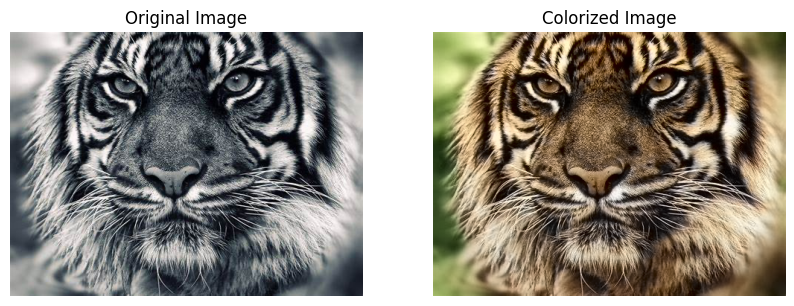

In [12]:
# Load the original image
original_image = plt.imread(path)

# Call the colorizer function and get the output path
output_path = colorizer(path)

# Load the colorized image
colorized_image = plt.imread(output_path)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

# Plot the colorized image
axs[1].imshow(colorized_image)
axs[1].set_title('Colorized Image')

# Remove the axis labels
for ax in axs:
    ax.axis('off')

# Display the figure
plt.show()
